In [1]:
from functools import reduce, partial

import numpy as np
import jax
from jax import random
import jax.numpy as jnp
import matplotlib.pyplot as plt

import nifty8 as ift
import nifty8.re as jft
from nifty8.re.tree_math import ShapeWithDtype

import jubik0 as ju

seed = 42
key = random.PRNGKey(seed)

Ciao is not sourced or installed. Therefore some operations can't be performed


# LEGACY Definitions

In [2]:
class NCopiesCorrField():
    def __init__(self, cf, N_copies, prefix):
        """
        Parameters:
        ----------
        N_copies: Tuple of int,
                Shape of the new field, implicitely defining the Number of copies. 
                Each of the correlated fields has the same power spectrum,
                but different excitations.
        cf: Correlated Field Model,
            from nifty.re

        returns:
        -------
        Model for multiple CorrelatedFields with the same pspec 
        but different xi_s.     
        """
        self.cf = cf
        self.N_copies = N_copies
        self.number = reduce(lambda x, y: x * y, self.N_copies)
        self.xi_key = prefix+ "xi"
        self.n_xis = cf.domain[self.xi_key].size
        self.target_flatten = ShapeWithDtype(shape=(self.n_xis, self.number))
        self.target = ShapeWithDtype(shape=((self.n_xis,) + self.N_copies))
        self.new_domain = self._extend_xi_domain()
        
    def _partly_apply_cf(self, pos_init):
        def partly(xi, xi_key):
            pos_init.tree.pop(xi_key)
            pos_init.tree.update({xi_key: xi})
            return self.cf(pos_init)
        return partly
        
    def _extend_xi_domain(self):
        dict = self.cf.domain.copy()
        dict.update({self.xi_key: self.target_flatten})
        return dict

    def partial_init_ncopies_model(self, pos_new):
        func = self._partly_apply_cf(pos_new)
        ncopies_model_func = jax.vmap(func, in_axes=(1, None), out_axes=1)
        res = ncopies_model_func(pos_new.tree[self.xi_key], self.xi_key)
        return res.reshape(self.cf.target.shape + self.N_copies)

    def build_model(self):       
        return jft.Model(self.partial_init_ncopies_model,
                         domain=self.new_domain,
                         target=self.target)

# Fields

In [3]:
e_dims = (12)
s_dims = (512,512)

RG_Energies = True
if RG_Energies:
    freqs = jnp.arange(0,12)
else:
    freqs = jnp.array([1,3,4,7,12,17,19.3])

## Spatial field

In [4]:
cf_zm = {"offset_mean": 0., "offset_std": (1e-3, 1e-4)}
cf_fl = {
    "fluctuations": (1.0, 5e-3),
    "loglogavgslope": (-3., 1e-2),
    "flexibility": (1e+0, 5e-1),
    "asperity": None,
    # "harmonic_type": "Fourier"
}
cfm = jft.CorrelatedFieldMaker("space_cf")
cfm.set_amplitude_total_offset(**cf_zm)
cfm.add_fluctuations(
    s_dims,
    distances=1. / s_dims[0],
    **cf_fl,
    prefix="ax1",
    non_parametric_kind="power"
)
correlated_field = cfm.finalize()

## Deviations from Powerlaw

In [5]:
dev_zm = {"offset_mean": 0., "offset_std": (1e-3, 1e-4)}
dev_fl = {
    "fluctuations": (1e-1, 5e-3),
    "loglogavgslope": (-1., 1e-2),
    "flexibility": (1e-3, 5e-1),
    "asperity": None,
    # "harmonic_type": "Fourier"
}
dev_cfm = jft.CorrelatedFieldMaker("dev_cf")
dev_cfm.set_amplitude_total_offset(**dev_zm)
dev_cfm.add_fluctuations(
    e_dims,
    distances=1. / e_dims,
    **dev_fl,
    prefix="ax1",
    non_parametric_kind="power"
)
dev_correlated_field = dev_cfm.finalize()

## Spectral Index $\alpha$

In [6]:
alpha_zm = {"offset_mean": -2.0, "offset_std": (1e-3, 1e-4)}
alpha_fl = {
    "fluctuations": (1e-1, 5e-3),
    "loglogavgslope": (-1., 1e-2),
    "flexibility": (1e+0, 5e-1),
    "asperity": (5e-1, 5e-2),
    #"harmonic_type": "Fourier"
}
alpha = jft.CorrelatedFieldMaker("alpha")
alpha.set_amplitude_total_offset(**alpha_zm)
alpha.add_fluctuations(
    s_dims,
    distances=1. / s_dims[0],
    **alpha_fl,
    prefix="ax1",
    non_parametric_kind="power"
)
alpha_field = alpha.finalize()

# Build Power Law

In [7]:
plaw = ju.build_power_law(freqs, alpha_field)

In [8]:
dev = jft.WienerProcess((0, 1), (1, 3), 2, name="marcent", N_steps=e_dims-1)

In [9]:
haargret = ju.MappedModel(dev, "marcent", s_dims, False)

# New Model

In [10]:
gen_mod = ju.GeneralModel({'spatial': correlated_field, 'freq_plaw': plaw, 'freq_dev':haargret}).build_model()

In [11]:
key, subkey = random.split(key)
pos_init = jft.Vector(jft.random_like(subkey, gen_mod.domain))
result = gen_mod(pos_init)

In [12]:
result.shape

(12, 512, 512)

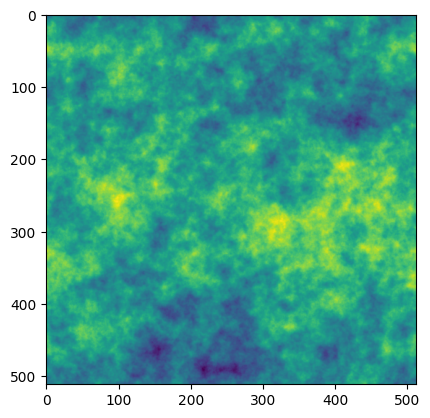

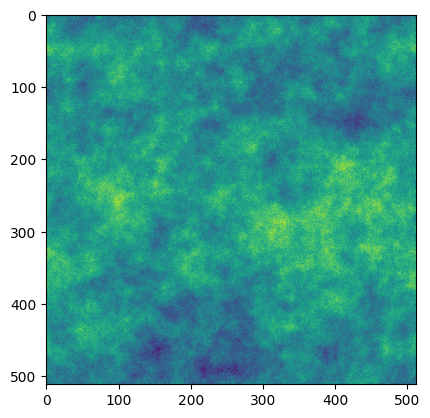

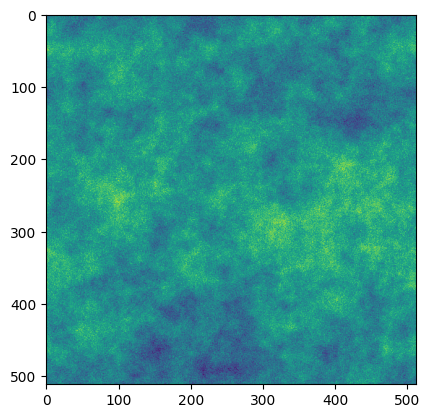

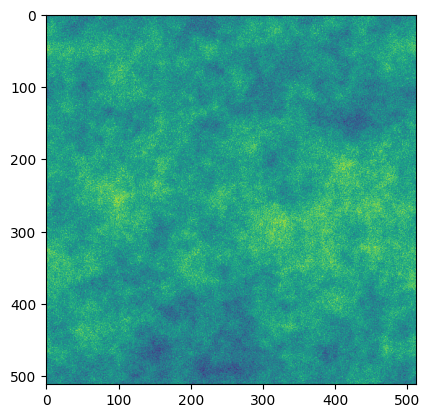

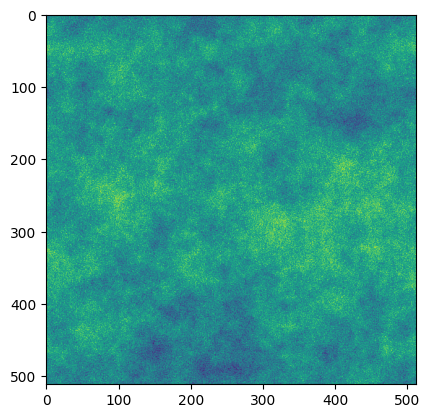

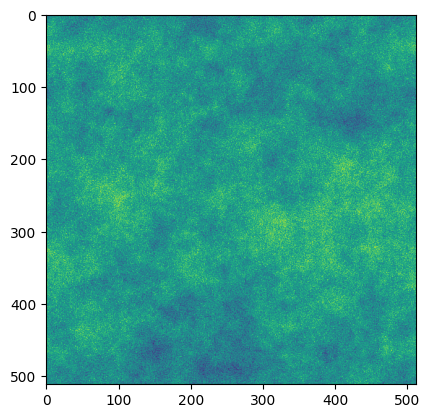

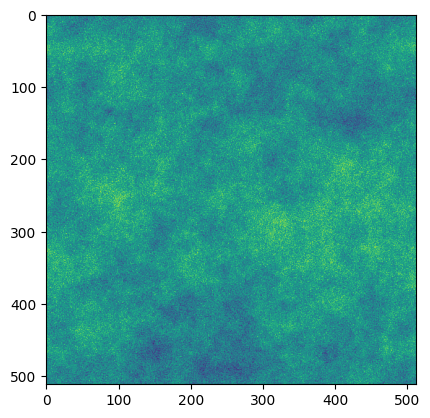

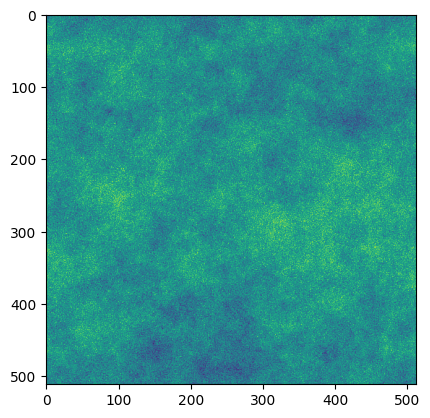

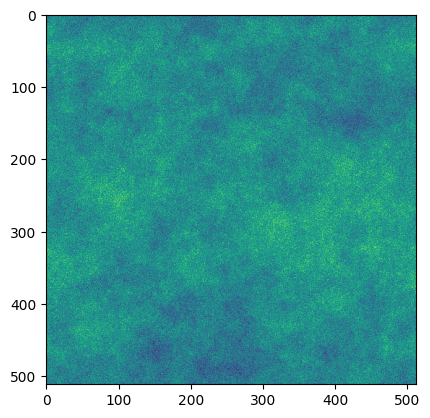

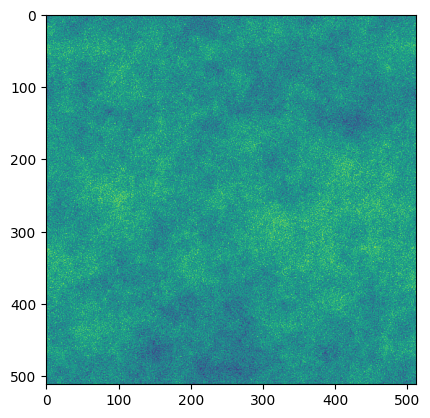

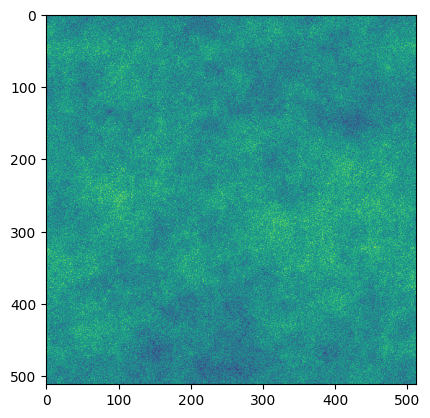

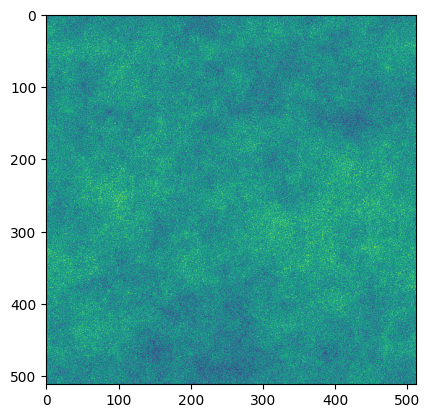

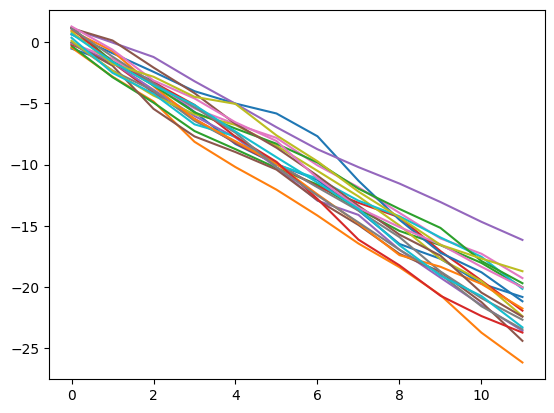

In [14]:
for j in range(12):
    plt.imshow(result[j,:,:])
    plt.show()
    plt.close()
for i in range(20):
    plt.plot(freqs,result[:,i,10])
plt.show()
plt.close()